### Logistic Regression Model

#### Data Preprocessing

In [3]:
#Import pre-processed data
import pandas as pd
import numpy as np

file = ".\\data\\processed\\stroke_processed.csv"
df = pd.read_csv(file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Get parameters, scale, get dummies

In [4]:
# Split dataset into stroke and non-stroke patients
strokes = df[df['stroke'] == 1]
non_strokes = df[df['stroke'] == 0]

In [5]:
#Split dataset into predictors and outcome vars
X = df.drop(columns=['stroke'])
y = df['stroke']

In [6]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(numerical_cols)
print(categorical_cols)

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [7]:
#change hypertension and heart disease into objects so they are flagged categorical
X[['hypertension', 'heart_disease']] = X[['hypertension', 'heart_disease']].astype('object')

#Update the numeric and categorical cols
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(numerical_cols) 
print(categorical_cols)

['age', 'avg_glucose_level', 'bmi']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [8]:
#Scale the numeric cols and get dummies for categoricals
from sklearn.preprocessing import StandardScaler

categorical_cols = [col for col in categorical_cols if col in X.columns]

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

numerical_cols = [col for col in numerical_cols if col in X.columns]

if numerical_cols:
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X.head()

,age,avg_glucose_level,bmi,gender_Male,hypertension_1,heart_disease_1,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.051434,2.706375,1.001234,True,False,True,True,False,True,False,True,True,False,False
1,0.786070,2.121559,0.000000,False,False,False,True,False,False,True,False,False,True,False
2,1.626390,-0.005028,0.468577,True,False,True,True,False,True,False,False,False,True,False
3,0.255342,1.437358,0.715418,False,False,False,True,False,True,False,True,False,False,True
4,1.582163,1.501184,-0.635711,False,True,False,True,False,False,True,False,False,True,False


In [9]:
print( 
    df[['gender', 'work_type', 'Residence_type', 'ever_married', 'smoking_status']].apply(lambda x: x.value_counts()) ,
    X.info() 
    )
#The reference categories are: female, no HTN, no heart disease, never married, gov worker, rural residence, unknown smoke

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   avg_glucose_level               5110 non-null   float64
 2   bmi                             5110 non-null   float64
 3   gender_Male                     5110 non-null   bool   
 4   hypertension_1                  5110 non-null   bool   
 5   heart_disease_1                 5110 non-null   bool   
 6   ever_married_Yes                5110 non-null   bool   
 7   work_type_Never_worked          5110 non-null   bool   
 8   work_type_Private               5110 non-null   bool   
 9   work_type_Self-employed         5110 non-null   bool   
 10  Residence_type_Urban            5110 non-null   bool   
 11  smoking_status_formerly smoked  5110 non-null   bool   
 12  smoking_status_never smoked     51

Check for collinearity

In [11]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

numerical_cols = [col for col in numerical_cols if col in X.columns]

X_with_const = add_constant(X[numerical_cols])

vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_cols

vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(len(numerical_cols))]

high_vif_features = vif_data[vif_data["VIF"] > 5]["Feature"].tolist()

numerical_cols = [col for col in numerical_cols if col not in high_vif_features]

print(f"VIF features: {high_vif_features}")
print(vif_data)

#VIFs are low, no collinearity between continuous variables

VIF features: []
             Feature       VIF
0                age  1.000000
1  avg_glucose_level  1.163836
2                bmi  1.070682


In [12]:
import statsmodels.api as sm

# One-hot encoding
X_copy = X.copy()

#Turn booleans into numeric
X_copy = X_copy.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Add constant term for intercept in VIF calculation
X_copy = add_constant(X_copy)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_copy.columns
vif_data["VIF"] = [variance_inflation_factor(X_copy.values, i) for i in range(X_copy.shape[1])]

print(vif_data)

#All VIF values are <5

                           feature        VIF
0                            const  18.372104
1                              age   2.862727
2                avg_glucose_level   1.108071
3                              bmi   1.297426
4                      gender_Male   1.027903
5                   hypertension_1   1.118200
6                  heart_disease_1   1.114637
7                 ever_married_Yes   1.985902
8           work_type_Never_worked   3.252774
9                work_type_Private   2.363911
10         work_type_Self-employed   1.937562
11            Residence_type_Urban   1.002045
12  smoking_status_formerly smoked   1.597938
13     smoking_status_never smoked   1.781265
14           smoking_status_smokes   1.530601


C:\Users\Catren-PC\AppData\Local\Temp\ipykernel_15232\2404430165.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_copy = X_copy.applymap(lambda x: 1 if x is True else (0 if x is False else x))


Split intro training and test sets

In [13]:
from sklearn.model_selection import train_test_split

#Change bools into 1 and 0 numeric
X = X.map(lambda x: 1 if x is True else (0 if x is False else x))

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Check the stroke distribution in the train and test sets, they should be the same
print(f"Training set class distribution: \n{y_train.value_counts(normalize=True)}")
print(f"Test set class distribution: \n{y_test.value_counts(normalize=True)}")

(4088, 14)
(4088,)
(1022, 14)
(1022,)
Training set class distribution: 
stroke
0    0.951321
1    0.048679
Name: proportion, dtype: float64
Test set class distribution: 
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


#### Model fit and performance metrics

In [14]:
#Fit model on training set
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [15]:
#Predict outcome on test set
y_pred = model.predict(X_test)

Accuracy: 0.7455968688845401
[[722 250]
 [ 10  40]]
F1 Score: 0.23529411764705882
Recall: 0.8
Precision: 0.13793103448275862
ROC AUC Score: 0.8436


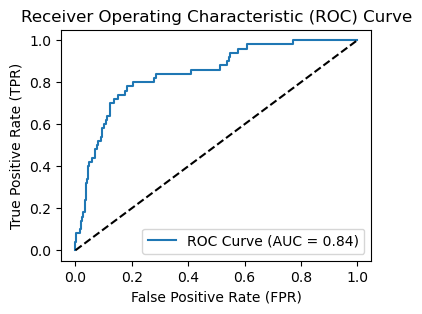

In [16]:
#Get performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, recall_score
import matplotlib.pyplot as plt

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Get probabilities for class 1 (stroke patients)
y_prob = model.predict_proba(X_test)[:, 1]  

#Calculate AUC and plot the ROC curve
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [17]:
#Check coefficient betas 
coefficients = model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df)

                           Feature  Coefficient  Abs_Coefficient
0                              age     1.883791         1.883791
7           work_type_Never_worked     0.884487         0.884487
4                   hypertension_1     0.587272         0.587272
13           smoking_status_smokes     0.317074         0.317074
5                  heart_disease_1     0.226957         0.226957
9          work_type_Self-employed    -0.222610         0.222610
1                avg_glucose_level     0.195903         0.195903
12     smoking_status_never smoked    -0.179038         0.179038
6                 ever_married_Yes    -0.162507         0.162507
10            Residence_type_Urban     0.146753         0.146753
11  smoking_status_formerly smoked     0.140204         0.140204
3                      gender_Male    -0.128275         0.128275
2                              bmi     0.072822         0.072822
8                work_type_Private     0.016658         0.016658


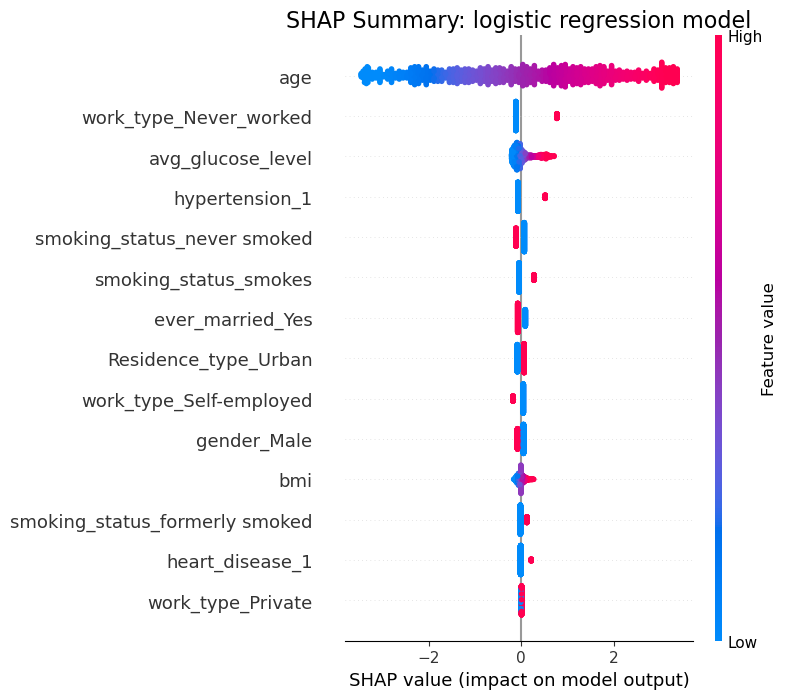

In [19]:
#SHAP Values
import shap
import numpy as np

explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer.shap_values(X_test)

plt.title("SHAP Summary: logistic regression model", fontsize=16)

shap.summary_plot(shap_values, X_test) 

plt.show()

#### Try tuning hyperparameters
Goal: optimize recall

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Catren-PC\miniconda3\envs\dsi_cat\lib\site-packages\sklearn\linear_model\_logistic.py", line 1

Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.99      0.65      0.79       972
           1       0.11      0.84      0.20        50

    accuracy                           0.66      1022
   macro avg       0.55      0.75      0.49      1022
weighted avg       0.94      0.66      0.76      1022

Accuracy: 0.662426614481409
[[635 337]
 [  8  42]]
F1 Score: 0.1958041958041958
Recall: 0.84
Precision: 0.11081794195250659
ROC AUC Score: 0.8336


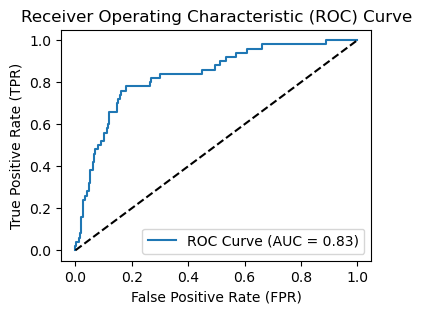

In [20]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report

model = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear',  'saga'], #'newton-cg', 'lbfgs',
    'max_iter': [200, 300] ,
    'class_weight': [{0: 1, 1: 5},{0: 1, 1: 10}, 'balanced']
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)

# Fit the model with the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model with the best hyperparameters
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

precision= precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Get probabilities for class 1 (stroke patients)
y_prob = best_model.predict_proba(X_test)[:, 1]  

#Calculate AUC and plot the ROC curve
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

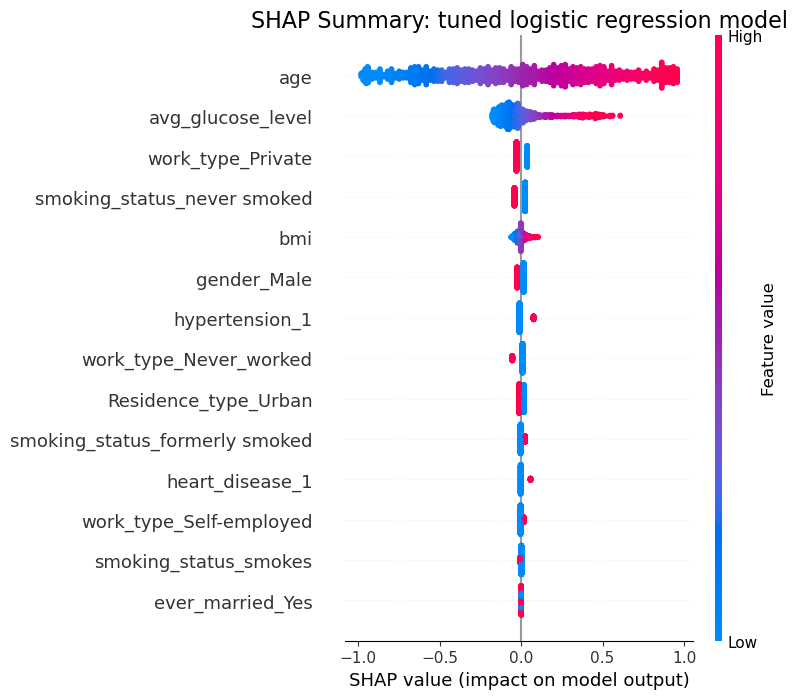

In [21]:
#SHAP Values for model optimized for recall

explainer = shap.LinearExplainer(best_model, X_test)
shap_values = explainer.shap_values(X_test)

plt.title("SHAP Summary: tuned logistic regression model", fontsize=16)

shap.summary_plot(shap_values, X_test) 

plt.show()

Conclusion 

SHAP summary shows that the top 5 important variables associated with stroke are Age, Average Glucose Level, Work Type, Smoking, and BMI.

Age: The most significant predictor of stroke, the higher the age the greater risk of stroke
<br>Average Glucose Level: The higher the average glucose level, the greater risk of stroke
<br>Work Type: Working in the private sector had lower risk of stroke than government workers
<br>Smoking: never smoking has lower risk of stroke compared to unknown smoking (limited interpretation due to missing data)
<br>BMI: The higher the BMI the greater risk of stroke